In [16]:
# Importing necessary libraries
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.optim import Adam
from torchsummary import summary
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
from torch.utils.data import TensorDataset, DataLoader, Dataset
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

### Facial keypoints detection using VGG16

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
root_dir = "./data/Facial_Keypoints_data/training"

In [4]:
# Loading the training data
all_img_paths = glob(os.path.join(root_dir, "*.jpg"))

In [5]:
data = pd.read_csv("./data/Facial_Keypoints_data/training_frames_keypoints.csv")

In [6]:
data.head() 
# In the data datframe, column 1 represents the name of the image(predictor variable), even columns represent 
# the x-axis value correponding to each of the 68 keypoints of the face and the odd columns 
# represent y-axis value correponsing to each of the 68 keypoints(target variable).

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [7]:
# Define a custom dataset class for facial keypoint detection
class FacesData(Dataset):
    
    # Initialization method
    def __init__(self, df):
        # Call the parent class's initialization method (important for Dataset)
        super(FacesData, self).__init__()
        
        # Store the DataFrame containing image paths and keypoints
        self.df = df
        
        # Define a normalization transformation using ImageNet statistics
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    # Define the length of the dataset (number of samples)
    def __len__(self):
        return len(self.df)
    
    # Method to get an image and its keypoints
    def __getitem__(self, ix):
        # Construct the image path by combining directory with file name from DataFrame
        img_path = "./data/Facial_Keypoints_data/training/" + self.df.iloc[ix, 0]
        
        # Read the image using OpenCV and normalize pixel values to [0, 1]
        img = cv2.imread(img_path)/255.
        
        # Extract the keypoints from the DataFrame for the given index (ix)
        kp = deepcopy(self.df.iloc[ix, 1:].tolist())
        
        # Normalize the x coordinates (divide by image width)
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        
        # Normalize the y coordinates (divide by image height)
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        
        # Combine the normalized x and y coordinates into a single list
        kp2 = kp_x + kp_y
        
        # Convert the keypoints list to a PyTorch tensor
        kp2 = torch.tensor(kp2)
        
        # Preprocess the image (resize, convert to tensor, normalize)
        img = self.preprocess_input(img)
        
        # Return the preprocessed image and corresponding keypoints
        return img, kp2
    
    # Method to preprocess the image (resize, normalize, etc.)
    def preprocess_input(self, img):
        # Resize the image to 224x224 pixels (common input size for CNNs)
        img = cv2.resize(img, (224, 224))
        
        # Convert the image to a PyTorch tensor and change the channel order to (C, H, W)
        img = torch.tensor(img).permute(2, 0, 1)
        
        # Normalize the image using the predefined mean and std (ImageNet stats)
        img = self.normalize(img).float()
        
        # Move the image tensor to the appropriate device (GPU or CPU)
        return img.to(device)
    
    # Method to load an image without keypoints (used for visualization or separate tasks)
    def load_img(self, ix):
        # Construct the image path
        img_path = "./data/Facial_Keypoints_data/training/" + self.df.iloc[ix, 0]
        
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        
        # Convert the image from BGR to RGB (OpenCV loads images in BGR by default)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        
        # Resize the image to 224x224 pixels
        img = cv2.resize(img, (224, 224))
        
        # Return the resized image
        return img

In [8]:
# Split the dataset into training and testing sets (80% train, 20% test)
train, test = train_test_split(data, test_size=0.2, random_state=101)

# Create a FacesData dataset for the training data
# Reset the index of the training set to ensure it is properly ordered (drop the old index)
train_dataset = FacesData(train.reset_index(drop=True))

# Create a FacesData dataset for the testing data
# Reset the index of the testing set to ensure it is properly ordered (drop the old index)
test_dataset = FacesData(test.reset_index(drop=True))

# Create a DataLoader for the training dataset with a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=32)

# Create a DataLoader for the testing dataset with a batch size of 32
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
# Define a function to initialize and return the model, criterion, and optimizer
def get_model():
    # Load a pre-trained VGG16 model from torchvision
    # `pretrained=True` loads the model with pre-trained weights from ImageNet
    SNet = models.vgg16(pretrained=True)
    
    # Freeze all the parameters of the model so that their gradients are not computed during training
    # This helps retain the pre-trained features and avoid updating them during training.
    for param in SNet.parameters():
        param.requires_grad = False

    # Modify the average pooling layer to include custom layers
    # Replace the existing avgpool layer (which was a global average pooling) with a custom one
    SNet.avgpool = nn.Sequential(
        # Apply a 3x3 convolution with 512 input channels and 512 output channels
        nn.Conv2d(512, 512, 3),
        
        # Apply a 2x2 max pooling operation to downsample the feature maps
        nn.MaxPool2d(2),
        
        # Flatten the feature maps to a 1D vector for fully connected layers
        nn.Flatten()
    )
    
    # Modify the classifier section of the VGG16 model to fit the task
    # Replace the original classifier with a new one, tailored for keypoint regression
    SNet.classifier = nn.Sequential(
        # First fully connected layer with input size of 2048 (from flattened feature maps) and output size 1000
        nn.Linear(2048, 1000),
        
        # Apply ReLU activation function (introduces non-linearity)
        nn.ReLU(),
        
        # Add a dropout layer to prevent overfitting (drop 60% of the neurons randomly during training)
        nn.Dropout(0.6),
        
        # Second fully connected layer with input size and ouput size 1000
        nn.Linear(1000, 1000),

        # Apply ReLU activatiom
        nn.ReLU(),
        
        # Add a dropout layer(shuts off 60% of neurons)
        nn.Dropout(0.6),
        
        # Output layer with 136 units (68 keypoints, each with x and y coordinates)
        nn.Linear(1000, 136),
        
        # Apply Sigmoid function to constrain the outputs to the [0, 1] range (since keypoints are normalized)
        nn.Sigmoid()
    )
    
    # Define the loss function (Mean Absolute Error Loss)
    # This is appropriate for regression tasks where you want to minimize the absolute error between predicted and true keypoints
    criterion = nn.L1Loss()
    
    # Define the optimizer (Adam optimizer)
    # Adam is an adaptive learning rate optimization algorithm that works well for most deep learning tasks
    optimizer = Adam(SNet.parameters(), lr=1e-4)
    
    # Return the model (SNet), loss function (criterion), and optimizer
    # Move the model to the appropriate device (GPU or CPU)
    return SNet.to(device), criterion, optimizer


In [10]:
SNet, criterion, optimizer = get_model()

c:\Users\SANDIP\Desktop\Vscode_projects\Computer_vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SANDIP\Desktop\Vscode_projects\Computer_vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def train_batch(img, kps, SNet, optimizer, criterion):
    # Set the model to training mode
    SNet.train()
    
    # Zero the gradients of the model's parameters (important before each backward pass)
    optimizer.zero_grad()
    
    # Perform a forward pass through the network using the input image (img)
    # .to(device) ensures the tensor is moved to the appropriate device (e.g., GPU)
    _kps = SNet(img.to(device))
    
    # Calculate the loss by comparing the predicted keypoints (_kps) and the ground truth keypoints (kps)
    # kps is also moved to the device (GPU or CPU) for consistency
    loss = criterion(_kps, kps.to(device))
    
    # Backpropagate the loss to compute gradients for the parameters of the network
    loss.backward()
    
    # Update the model's parameters using the optimizer
    optimizer.step()
    
    # Return the computed loss to monitor or log the training progress
    return loss


In [12]:
@torch.no_grad()  # Disables gradient calculation to reduce memory usage and speed up computation
def validate_batch(img, kps, SNet, criterion):
    # Set the model to evaluation mode 
    SNet.eval()
    
    # Perform a forward pass through the network using the input image (img)
    # .to(device) ensures that the image tensor is moved to the appropriate device (e.g., GPU)
    _kps = SNet(img.to(device))
    
    # Calculate the loss by comparing the predicted keypoints (_kps) and the ground truth keypoints (kps)
    # kps is also moved to the device for consistency
    loss = criterion(_kps, kps.to(device))
    
    # Return the predicted keypoints and the loss value for logging or evaluation purposes
    return _kps, loss


In [13]:
# Initialize empty lists to store the training and testing losses for each epoch
train_loss, test_loss = [], []

# Set the number of epochs for training
n_epochs = 50

# Loop through each epoch
for epoch in range(n_epochs):
    print(f"Epoch: {epoch + 1}/50")  # Print the current epoch number
    epoch_train_loss, epoch_test_loss = 0, 0  # Initialize loss values for this epoch
    
    # Training phase
    for ix, (img, kps) in enumerate(train_loader):  # Loop through the training dataset
        # Call the train_batch function which performs a training step and returns the loss
        loss = train_batch(img, kps, SNet, optimizer, criterion)
        epoch_train_loss += loss.item()  # Add the loss of the current batch to the total training loss
    
    # Average the training loss over the entire training dataset
    epoch_train_loss /= (ix + 1)  # Divide by number of batches to get average loss
    
    # Validation phase (testing phase)
    for ix, (img, kps) in enumerate(test_loader):  # Loop through the testing dataset
        # Call the validate_batch function which performs a validation step and returns the predicted values and loss
        ps, loss = validate_batch(img, kps, SNet, criterion)
        epoch_test_loss += loss.item()  # Add the loss of the current batch to the total testing loss
    
    # Average the testing loss over the entire testing dataset
    epoch_test_loss /= (ix + 1)  # Divide by number of batches to get average loss
    
    # Print the losses for this epoch
    print(f"training loss: {epoch_train_loss} test loss: {epoch_test_loss}")
    
    # Append the average losses of this epoch to the respective lists for tracking
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)


Epoch: 1/50
training loss: 0.05737332640023067 test loss: 0.037684527479789474
Epoch: 2/50
training loss: 0.04259669275461942 test loss: 0.03106226297942075
Epoch: 3/50
training loss: 0.035726174883458806 test loss: 0.029706375334750523
Epoch: 4/50
training loss: 0.03309954587241699 test loss: 0.03215485531836748
Epoch: 5/50
training loss: 0.030735783364580965 test loss: 0.028187690302729607
Epoch: 6/50
training loss: 0.02851143061857799 test loss: 0.024111458608372646
Epoch: 7/50
training loss: 0.02715465813960837 test loss: 0.0252074935388836
Epoch: 8/50
training loss: 0.02629370482146055 test loss: 0.029638933525844055
Epoch: 9/50
training loss: 0.02569808035917666 test loss: 0.03220149773088368
Epoch: 10/50
training loss: 0.025253683414267397 test loss: 0.03360354612496766
Epoch: 11/50
training loss: 0.02410830375363772 test loss: 0.03107393541457978
Epoch: 12/50
training loss: 0.02349157522207704 test loss: 0.02597791108895432
Epoch: 13/50
training loss: 0.022972398940687894 test 

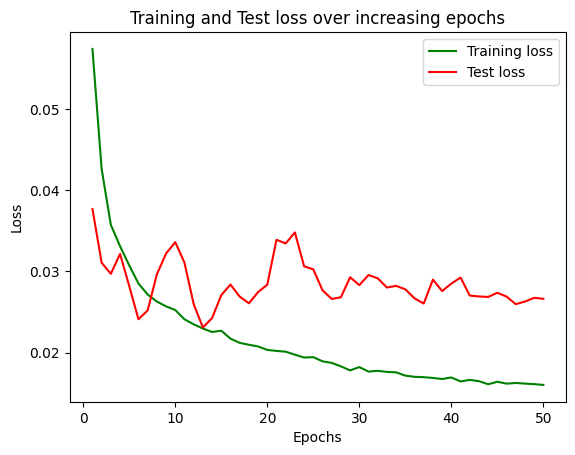

In [14]:
# Create an array of epochs starting from 1 to 50 (inclusive)
epochs = np.arange(50) + 1  # np.arange(50) gives values from 0 to 49, so we add 1 to start from 1

# Plot the training loss vs. epoch numbers, using green color ('g') and label "Training loss"
plt.plot(epochs, train_loss, "g", label="Training loss")

# Plot the test loss vs. epoch numbers, using red color ('r') and label "Test loss"
plt.plot(epochs, test_loss, "r", label="Test loss")

# Set the title for the plot
plt.title("Training and Test loss over increasing epochs")

# Label the x-axis as "Epochs"
plt.xlabel("Epochs")

# Label the y-axis as "Loss"
plt.ylabel("Loss")

# Display the legend on the plot to differentiate between training and test loss
plt.legend()

# Display the plot
plt.show()


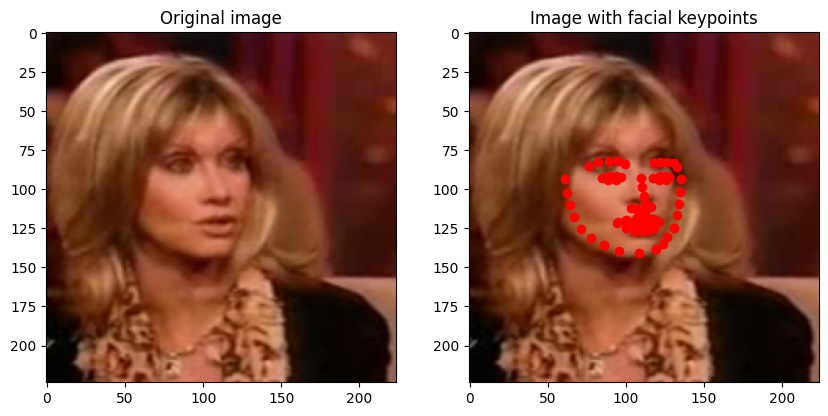

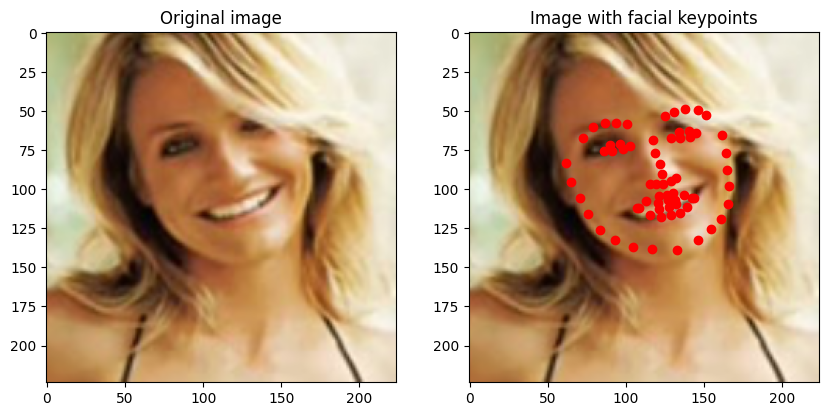

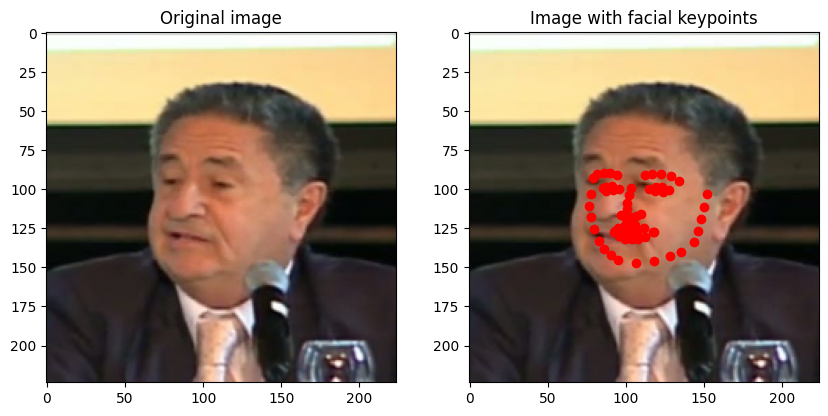

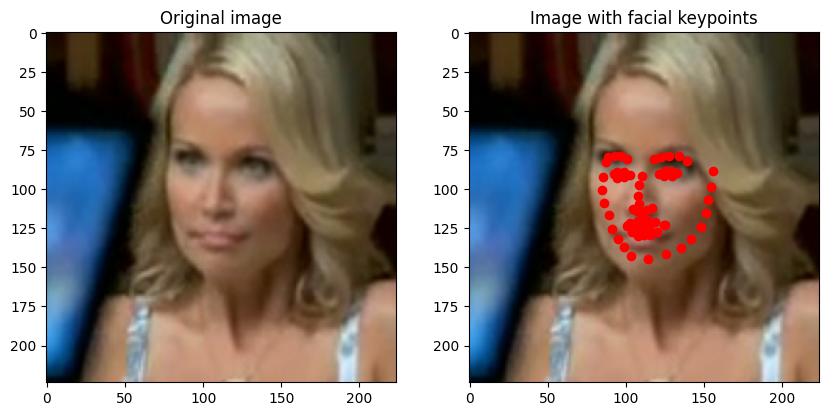

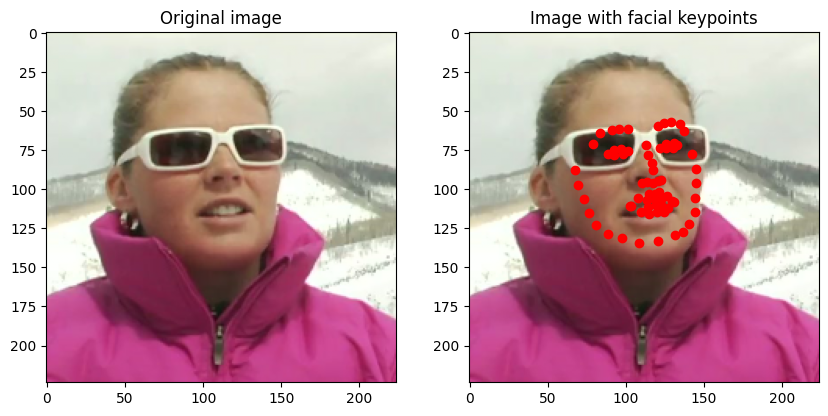

In [22]:
# Loop 5 times to display 5 different images with their facial keypoints
for _ in range(5):
    # Randomly select an index from the test dataset
    ix = random.randint(0, len(test_dataset))

    # Create a new figure for each image with a larger size (10x10 inches)
    plt.figure(figsize=(10, 10))
    
    # Subplot for displaying the original image
    plt.subplot(221)  # 2x2 grid, position 1 (top-left)
    plt.title("Original image")  # Title for the original image
    im = test_dataset.load_img(ix)  # Load the image from the test dataset using its index
    plt.imshow(im)  # Display the image
    plt.grid(False)  # Hide the grid around the image
    
    # Subplot for displaying the image with facial keypoints
    plt.subplot(222)  # 2x2 grid, position 2 (top-right)
    plt.title("Image with facial keypoints")  # Title for the image with keypoints
    x, _ = test_dataset[ix]  # Retrieve the input image data and ignore the label
    plt.imshow(im)  # Display the same image again
    
    # Pass the image through the model (SNet) to get the predicted keypoints
    kp = SNet(x[None]).flatten().detach().cpu()  # Run the model, flatten the result, and move to CPU
    
    # Plot the facial keypoints on the image
    # First 68 values correspond to x-coordinates, the next 68 correspond to y-coordinates
    plt.scatter(kp[:68]*224, kp[68:]*224, c="r")  # Multiply by 224 to scale coordinates to image size and plot in red
    
    plt.grid(False)  # Hide the grid around the image with keypoints
    
    # Show the plot with the image and keypoints
    plt.show()
